# 1D gaussian toy model

In [1]:

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
rc('axes', labelsize=20, titlesize=20)

In [3]:
import numpy as np
import triangle
from clerk.stats.distances import mahalanobis
import abcpmc 

#np.random.seed(987654321)

# Data

In [4]:
mean = 1
sigma = 1
n = 10000
y = np.random.normal(mean, sigma, n)

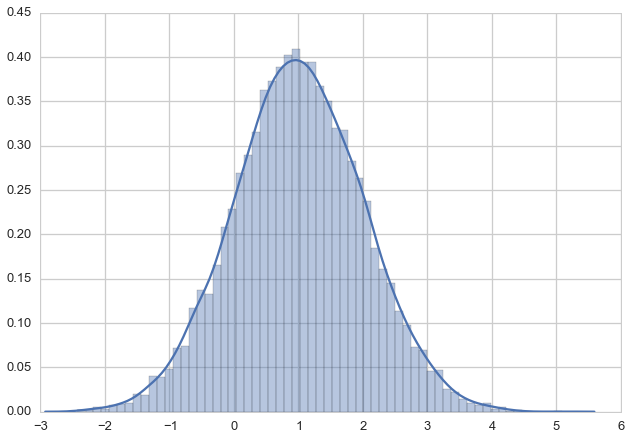

In [5]:
sns.distplot(y)

# Setup

In [6]:
prior = abcpmc.TophatPrior([-5], [5])

In [7]:
def mean_dist(x, y):
    return np.abs(np.mean(x, axis=0) - np.mean(y, axis=0))

dist = mean_dist

In [8]:
def create_new_sample(theta):
    return np.random.normal(theta, sigma, n)
postfn = create_new_sample

# Verification

In [9]:
theta = prior()
print theta
x = postfn([mean])
d = dist(x, y)
print d

[-3.25111378]
0.00638464647016


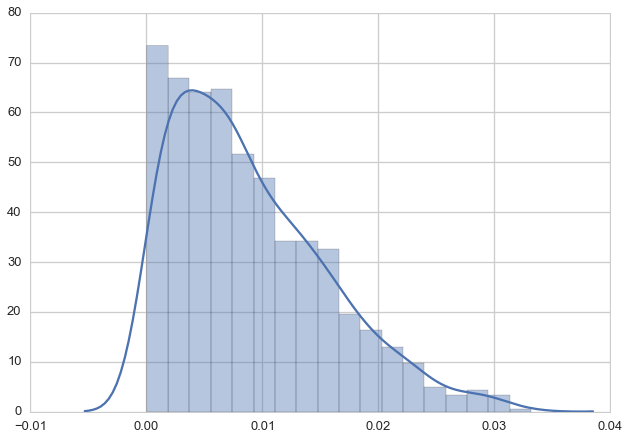

In [10]:
distances = [dist(y, postfn(mean)) for _ in range(1000)]
sns.distplot(distances)

# ABC sampling with PMC

In [11]:
def sample(T, eps_val, eps_min):
    abcpmc_sampler = abcpmc.Sampler(N=2000, Y=y, postfn=postfn, dist=dist, threads=8)
    eps = abcpmc.ConstEps(T, eps_val)
    pools = []
    for pool in abcpmc_sampler.sample(prior, eps):
        print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, eps(pool.t), pool.ratio))
        
        eps.eps = np.percentile(pool.dists, 90)
        if eps.eps < eps_min:
            eps.eps = eps_min
            
        pools.append(pool)
        
    abcpmc_sampler.close()
    
    return pools


In [12]:
T=38
eps=0.5
pools = sample(T, eps, sigma/sqrt(n))

T: 0, eps: 0.5000, ratio: 0.0996
T: 1, eps: 0.4620, ratio: 0.5944
T: 2, eps: 0.4138, ratio: 0.5954
T: 3, eps: 0.3521, ratio: 0.5812
T: 4, eps: 0.2985, ratio: 0.5896
T: 5, eps: 0.2623, ratio: 0.6268
T: 6, eps: 0.2312, ratio: 0.6200
T: 7, eps: 0.1992, ratio: 0.6464
T: 8, eps: 0.1806, ratio: 0.5912
T: 9, eps: 0.1572, ratio: 0.6177
T: 10, eps: 0.1345, ratio: 0.6020
T: 11, eps: 0.1184, ratio: 0.5831
T: 12, eps: 0.1030, ratio: 0.5831
T: 13, eps: 0.0912, ratio: 0.5739
T: 14, eps: 0.0828, ratio: 0.5774
T: 15, eps: 0.0725, ratio: 0.5872
T: 16, eps: 0.0634, ratio: 0.6139
T: 17, eps: 0.0568, ratio: 0.5838
T: 18, eps: 0.0505, ratio: 0.6085
T: 19, eps: 0.0460, ratio: 0.6161
T: 20, eps: 0.0412, ratio: 0.6133
T: 21, eps: 0.0352, ratio: 0.5711
T: 22, eps: 0.0313, ratio: 0.5543
T: 23, eps: 0.0281, ratio: 0.5319
T: 24, eps: 0.0243, ratio: 0.5169
T: 25, eps: 0.0220, ratio: 0.4903
T: 26, eps: 0.0197, ratio: 0.4688
T: 27, eps: 0.0179, ratio: 0.4555
T: 28, eps: 0.0159, ratio: 0.4720
T: 29, eps: 0.0141, rati

# Postprocessing

In [13]:
def plot_pool(prob, samples):
    prob = np.array(prob).flatten()
    samples = np.vstack(samples)
    
    sns.distplot(prob)
    show()
    sns.distplot(samples, axlabel=r'$\theta$')
    #savefig("1d_gauss_posterior.pdf")
    show()
    sample_mean = np.mean(samples, axis=0)
    print(u"mean: {0:>.4f} \u00B1 {1:>.4f}".format(float(np.mean(samples, axis=0)), float(np.std(samples, axis=0))))


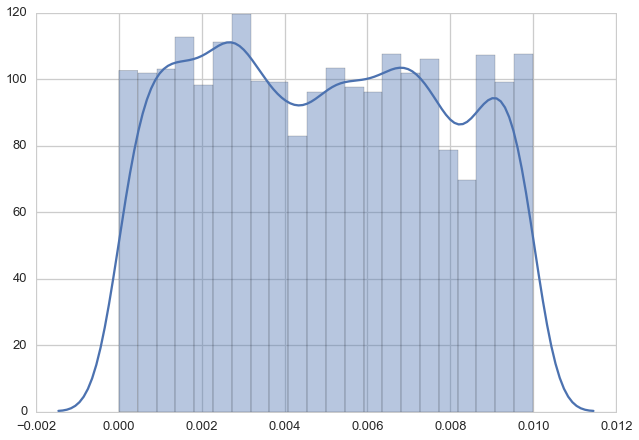

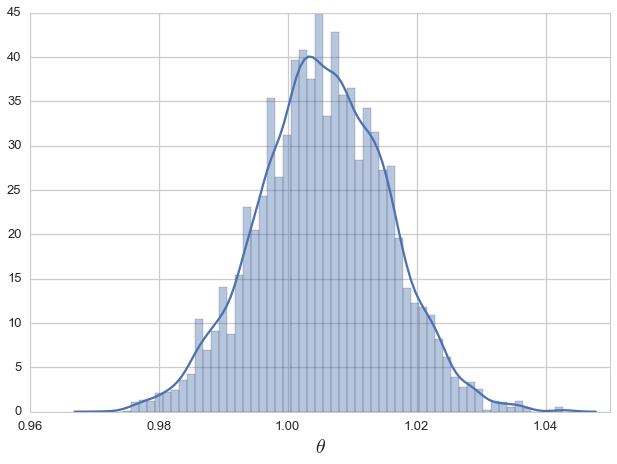

mean: 1.0055 ± 0.0100


In [14]:
offset = 33
samples = np.array([pool.thetas for pool in pools])
distances = np.array([pool.dists for pool in pools])

plot_pool(distances[offset:], samples[offset:])

In [15]:
var_vals = np.var((samples), axis=1)
eps_values = np.array([pool.eps for pool in pools])

(-0.01, 0.10000000000000001)

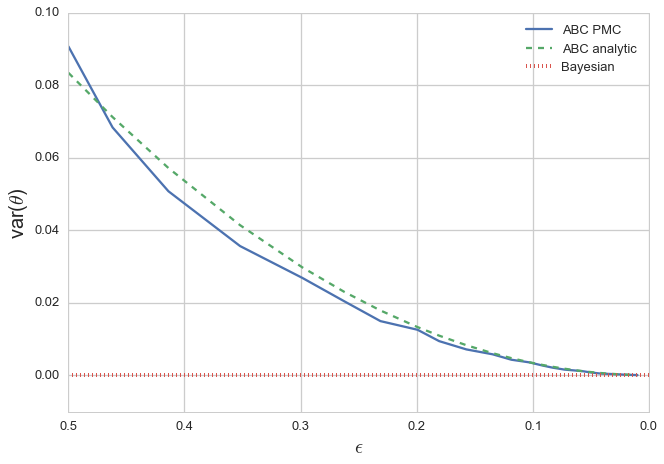

In [16]:
max_eps = 38
f, ax = subplots(1,1)

ax.plot(eps_values, var_vals[:max_eps], "-" ,label="ABC PMC")

ax.plot(eps_values, (float(sigma)**2/n + eps_values[:max_eps]**2/3), "--", label="ABC analytic")

ax.axhline(1e-4, linestyle=":", linewidth=4, color=sns.xkcd_rgb["pale red"], label="Bayesian")


#ticks = xticks()[0][:-1]
#xticks(ticks, ["{0:>4.3f}".format(eps) for eps in eps_values[ticks.tolist()]], rotation=70)
#ax.semilogy()
ax.set_ylabel(r"var($\theta$)")
ax.set_xlabel(r"$\epsilon$")
ax.legend(loc="best")
ax.invert_xaxis()
ylim([-.01, None])
#savefig("1d_gauss_variance.pdf")

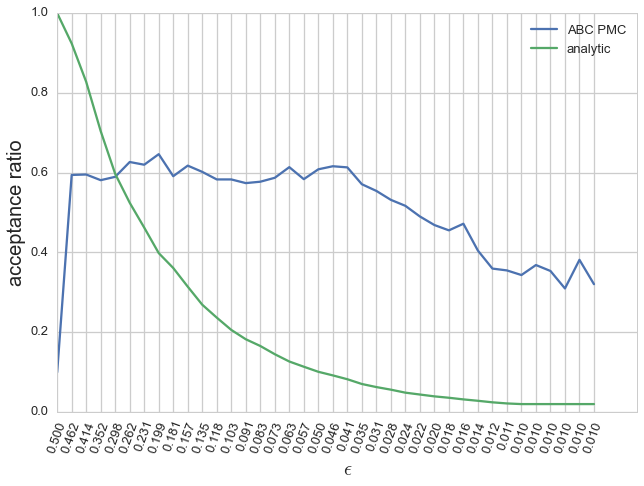

In [17]:
acc_ratios = np.array([pool.ratio for pool in pools])
plot(acc_ratios, label="ABC PMC")
plot(2 * np.array(eps_values), label="analytic")
xticks(np.arange(len(eps_values)), ["{0:>4.3f}".format(eps) for eps in eps_values], rotation=70)
#semilogy()
ylabel("acceptance ratio")
xlabel(r"$\epsilon$")
legend(loc="best")

In [18]:
from scipy.special import erf
def p_theta_eta(theta, eta):
    phi = lambda t: (1 + erf(t / np.sqrt(2))) / 2
    ybar = np.mean(y, axis=0)
    return 1. / (2 * eta) *(phi((ybar - theta + eta) / (sigma / np.sqrt(n))) - phi((ybar - theta - eta) / (sigma / np.sqrt(n))) )

In [19]:
def get_ticks(ticks, num=7):
    return [float("{0:<.2f}".format(tick)) for tick in np.linspace(ticks[0], ticks[-1], 7)]

In [20]:
from scipy.stats import norm

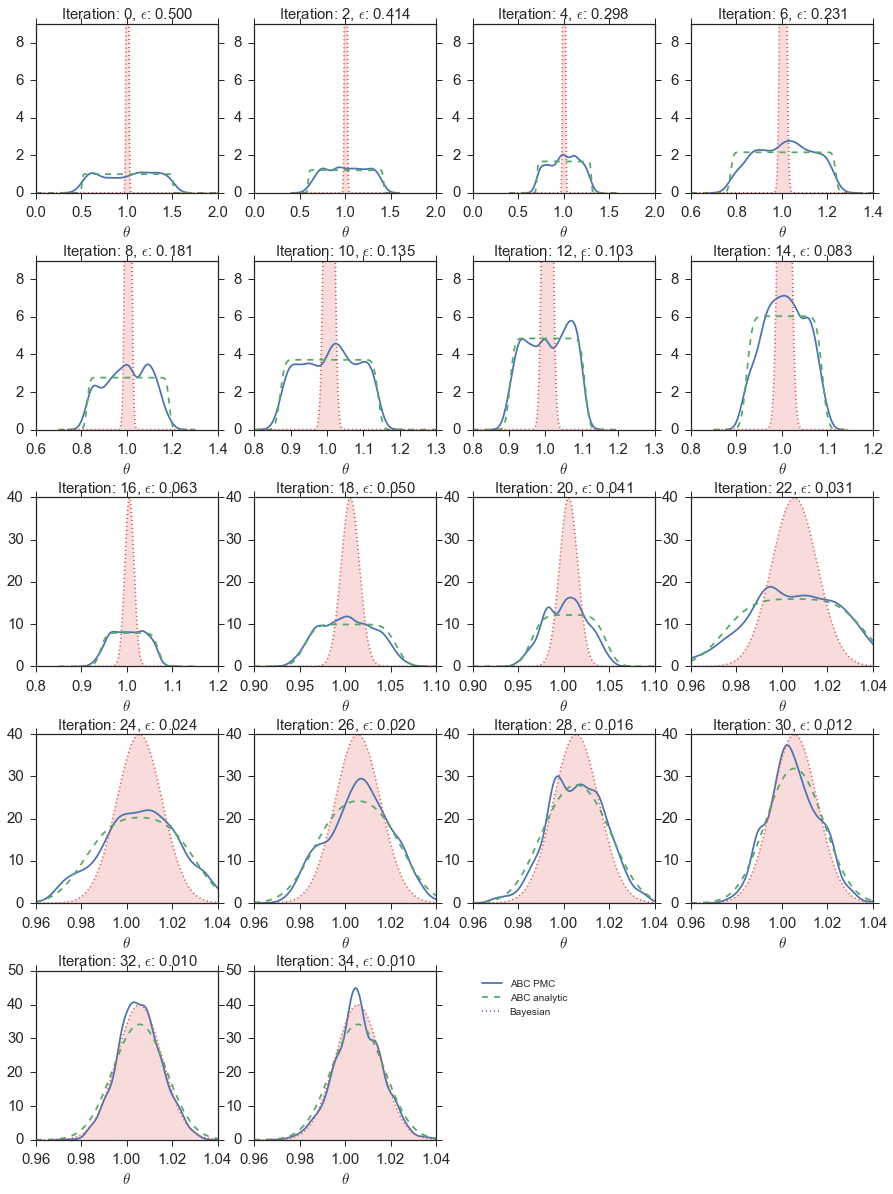

In [30]:
nbins = 6
rc('axes', labelsize=40, titlesize=30)
#rc("ticks", size=20)
sns.set(style="ticks")
with mpl.rc_context(rc={"figure.figsize": [15, 20]}):
    for i in range(36/2):
        subplot(5, 4, i+1)
        title(r"Iteration: {0}, $\epsilon$: {1:>4.3f}".format(i*2, eps_values[i*2]), size=15)
        ax = sns.distplot(samples[i*2], hist=False, axlabel=r'$\theta$', hist_kws={"rotation":.3, "fontsize":30})
        ax.set_xlabel(r'$\theta$', size=15)
        ax.locator_params(axis = 'x', nbins = nbins)
        ax.locator_params(axis = 'y', nbins = 5)
        min_val, max_val = ax.get_xlim()
        x_grid = np.linspace(min_val, max_val, 1000)
        plot(x_grid, p_theta_eta(x_grid, eps_values[i*2]), "--")
        if i*2>=22:
            xlim([0.96, 1.04])
        
        if i*2<=14:
            ylim([None, 9])
        
        rv = norm(loc=np.mean(y), scale=1/np.sqrt(n))
        plot(x_grid, rv.pdf(x_grid), ":", color=sns.xkcd_rgb["pale red"])
        fill(x_grid, rv.pdf(x_grid), color=sns.xkcd_rgb["pale red"], alpha=0.2)
        tick_params(axis='both', which='major', labelsize=15)
    #i = 37
    #subplot(5, 4, 20)
    #title(r"Iteration: {0}, $\epsilon$: {1:>4.3f}".format(i, eps_values[i]))
    #ax = sns.distplot(samples[i], hist=False, axlabel=r'$\theta$')
    #ax.locator_params(axis = 'x', nbins = nbins)
    #min_val, max_val = ax.get_xlim()
    #x_grid = np.linspace(min_val, max_val, 1000)
    #plot(x_grid, p_theta_eta(x_grid, eps_values[i]))
    
    ax = subplot(5, 4, i+2)
    plot(1, label="ABC PMC")
    plot(1, "--", label="ABC analytic")
    plot(1, ":", label="Bayesian")
    legend(loc=2)
    ax.set_axis_off()
    subplots_adjust(hspace = 0.40)
    
    savefig("1d_gauss_posterior_evolution.pdf")

In [20]:
from scipy.stats import gaussian_kde

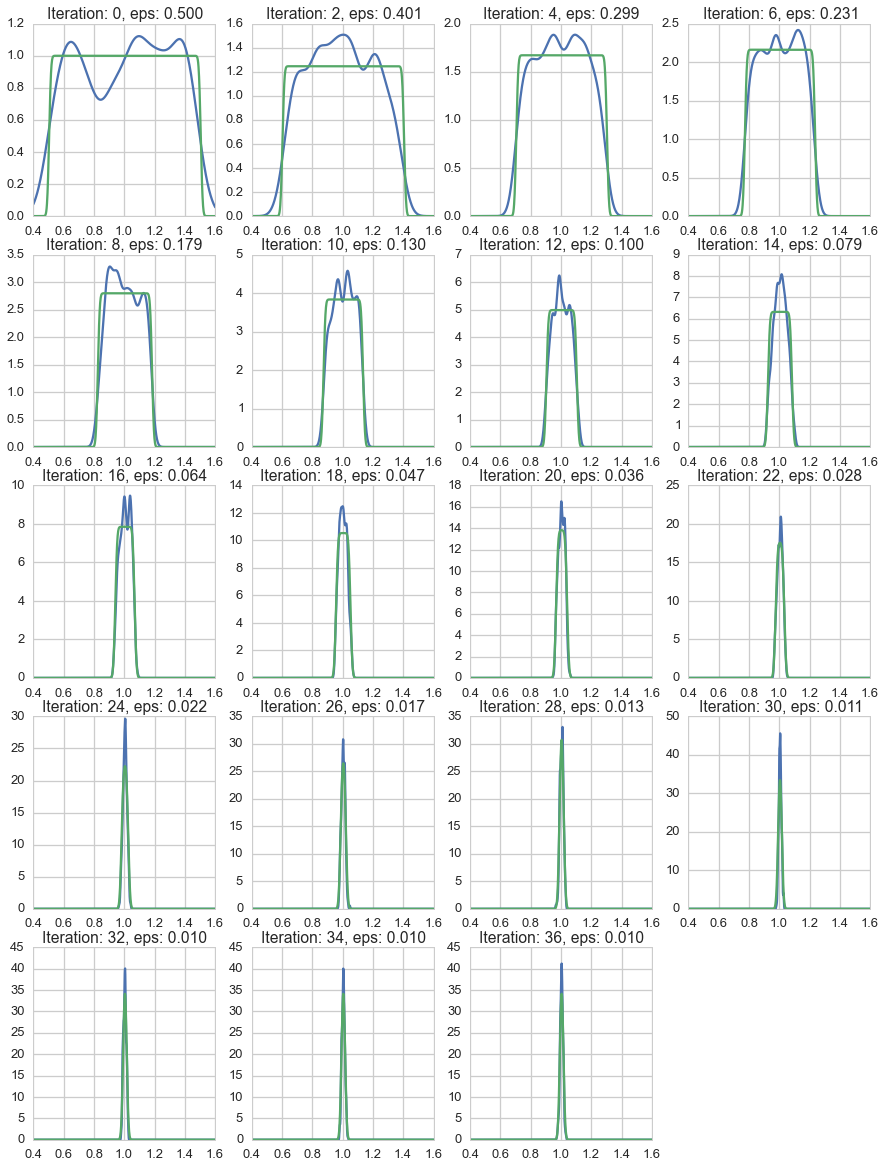

In [21]:
x_grid = np.linspace(0.4, 1.6, 1000)
with mpl.rc_context(rc={"figure.figsize": [15, 20]}):
    for i in range(len(samples)/2):
        subplot(5, 4, i+1)
        title("Iteration: {0}, eps: {1:>4.3f}".format(i*2, eps_values[i*2]))
        
        kde = gaussian_kde(np.array(samples[i*2])[:, 0])
        plot(x_grid, kde(x_grid))
        plot(x_grid, p_theta_eta(x_grid, eps_values[i*2]))